In [2]:
from visualizer import calibration
import visual

from PyQt5 import QtCore
import tifffile
from skimage.io import imread
from skimage.io.collection import alphanumeric_key
from dask import delayed
from glob import glob
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import napari
from napari import Viewer
import os
import zarr
from skimage.registration import phase_cross_correlation
import cv2 as cv
from skimage import io
from skimage.morphology import skeletonize
from skan import Skeleton
import scipy.ndimage as ndi
import cupy as cp 
import waveorder as wo
from waveorder.io.multipagetiff import  MicromanagerOmeTiffReader
from aicsimageio import AICSImage,imread, imread_dask
import cv2 as cv
import analysis_utils as au
import bottleneck as bn
import pandas as pd

%gui qt 
%matplotlib inline
plt.style.use('dark_background')
from skimage.measure import find_contours


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [3]:
viewer = napari.Viewer()

Assistant skips harvesting pyclesperanto as it's not installed.


c:\ProgramData\Anaconda3\envs\m25-py39\lib\site-packages\napari_tools_menu\__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [4]:
### Enter the filepath for the data directory
main_dir =r'F:\DATA\20220507_M25_ZW495_9'   #5 fast dynamics of big worm
###Enter the filepath for background images
bg_dir = r'F:\Test_ignore\20220513_M25_bg_16bit'
### Enter the filepath for Calibration Dataset (PSF) or offset file
psf_dir = r'F:\Test_ignore\220508_190nmSteps_postitive2negative_1'
# psf_dir = r'F:\Test_ignore\220508_380nmSteps_minusplus_reversed_1'
#Get Folders and files
main_dirs = sorted(glob(main_dir + '/CAM*/'), key=alphanumeric_key)
bg_folders = sorted(glob(bg_dir + '/CAM*/'), key=alphanumeric_key)

# Load offsets from desired folder 
processed_files = main_dir + '/'+'processed_files'
if not os.path.exists(processed_files):
    os.makedirs(processed_files)

offset_dir = os.path.join(psf_dir + '/'+'processed_files')
offsets_file = os.path.join(offset_dir,"offsets.csv")
offsets_file_pcc = os.path.join(offset_dir,"offsets_pcc.csv")

if os.path.exists(offsets_file):
    with open(offsets_file) as file_name:
        print("loading offsets")
        offsets = np.loadtxt(file_name, delimiter=",")

if os.path.exists(offsets_file_pcc):
    with open(offsets_file) as file_name:
        print("loading offsets")
        offsets_pcc = np.loadtxt(file_name, delimiter=",")
## Quick Visualizer of the selected planes
# center_planes = calibration.lazy_dask_stack(main_dir,num_cams=5,px_depth='uint16', height=608, width =608)
# napari.add_image(center_planes, name='center_planes',scale=[z_scale,1,1],multiscale=False)

In [5]:
# Scope Parameters
cam_px = 6.0e-6
totalmag = 15.75
zstep = 2e-6

px_size_img = cam_px/totalmag
z_scale = zstep/px_size_img

### LOAD DATASET

In [19]:
### For preexisting tiff saved datasets
filename = 'aligned_stack.zarr'
filepath_save = os.path.join(processed_files,filename)
zarr_stack = zarr.load(filepath_save)
#Compensate center plane
zarr_stack[:,12,:,:]=zarr_stack[:,12,:,:]*1.23077


In [7]:
# viewer.add_image(zarr_stack)

In [8]:
# #Reading RAW 1 plane 
# folder = main_dirs[12]
# file_extension = folder + '/' + '*.raw'
# file_names = sorted(glob(file_extension),key=alphanumeric_key)
# raw_ds = calibration.dask_raw_ds(folder,px_depth='uint16', width=608,height=608)
# dask_raw_ds = da.stack(raw_ds,axis=1)
# dask_raw_ds.shape

In [20]:
# #Cropping stack for testing 
crop_stack = (zarr_stack[120:220,:,:,:].astype(np.float32)).sum(axis=1)
# crop_stack = wo.im_bit_convert(crop_stack,bit=16,norm=True)
# crop_stack =zarr_stack[120:220,12,:,:]  #for the single plane

# crop_stack =(zarr_stack.astype(np.float32)).sum(axis=1)  #for the single plane
zarr_stack=[]
# crop_stack =(zarr_stack[110:200,10:17,:,:].astype(np.float32)).sum(axis=1)  #for the single plane
crop_stack = wo.im_bit_convert(crop_stack,bit=16,norm=True)

crop_stack = np.expand_dims(crop_stack,axis=1)



In [10]:
# import tifffile
# filename = 'sum_stack' + '.ome.tif'
# filepath_save = os.path.join(processed_files,filename)
# print(filepath_save)
# tifffile.imwrite(filepath_save,crop_stack)

In [11]:
da_crop_stack= da.asarray(crop_stack)
viewer.add_image(da_crop_stack)

<Image layer 'da_crop_stack' at 0x21902a274f0>

In [11]:
viewer.add_image(crop_stack)

<Image layer 'crop_stack' at 0x2bb095b0bb0>

In [12]:
from skimage.morphology import disk
# binary_stack =crop_stack>1000  # the sum projection
binary_stack =crop_stack>15000  # the sum projection for 10 to 17 planes
t,c,x,y = binary_stack.shape
viewer.add_image(crop_stack[:t])
binary_stack2 = np.copy(binary_stack[:t])
viewer.add_image(binary_stack2, opacity=0.5)

<Image layer 'binary_stack2' at 0x219130e2e20>

In [13]:
#TODO: another thing to try is to do two separate masks for the different intensitie. OR them together to mix and then do morphology
for i in range(t):
    ndi.binary_closing(binary_stack[i,0] , disk(20),output=binary_stack2[i,0])
    ndi.binary_erosion(binary_stack2[i,0],disk(1), output=binary_stack2[i,0])
    ndi.gaussian_filter(binary_stack2[i,0],sigma=1,output=binary_stack2[i,0])
    # ndi.gaussian_filter(binary_stack2[i,0],sigma=1,output=binary_stack2[i,0])
viewer.add_image(binary_stack2, opacity=0.5)

<Image layer 'binary_stack2 [1]' at 0x21902a01760>

## SKELETON 🦴

In [14]:
#SKELETONIZEEE 
from skan import Skeleton
# perform skeletonization
skeleton =np.array([skeletonize(binary_stack2[i]) for i in range(t)])
print(skeleton.shape)

viewer.add_image(skeleton, colormap='magenta', blending='additive')
sk_skeleton =[Skeleton(skeleton[i]) for i in range(skeleton.shape[0])]
print(len(sk_skeleton))
print(skeleton.shape)


(100, 1, 608, 608)
100
(100, 1, 608, 608)


In [12]:
# #Make the skeleton Points
# select_coords =[]
# i=0
# for k in range(len(sk_skeleton)):
#     coords =sk_skeleton[k].path_coordinates(0)
#     interp_coord = au.interpolate_skeleton(coords,50)
#     # print(interp_coord)
#     for c_num in range(interp_coord.shape[0]):
#         select_coords.append([k,i,interp_coord[c_num,1],interp_coord[c_num,2]])
# select_coords=np.array(select_coords)
# viewer.add_points(select_coords, face_color='cornflowerblue')

In [16]:
# skel_x = interp_coord[:, 1]
# skel_y = interp_coord[:, 2]
# d_x = np.diff(skel_x)
# d_y = np.diff(skel_y)
# # calculate tangent angles.  atan2 uses angles from -pi to pi
# angles = np.arctan2(d_y, d_x)
# angles=np.degrees(angles)

# distance =[]
# for i in range(angles.size-1):
#     distance.append(angle_distance(angles[i],angles[i+1]))
# distance = np.array(distance)
# print(distance.shape)

In [17]:
# ##Combining both coordinate interpolation with boxes
# select_coords =[]
# layer_boxes = []
# i=0
# n_interpol = 30
# for k in range(len(sk_skeleton)):
#     coords =sk_skeleton[k].path_coordinates(0)
#     interp_coord = au.interpolate_skeleton(coords,n_interpol)
#     for c_num in range(interp_coord.shape[0]):
#         select_coords.append([k,i,interp_coord[c_num,1],interp_coord[c_num,2]])
#         if c_num<(interp_coord.shape[0]-1):
#             left_box, right_box  = au.create_skeleton_box(interp_coord[c_num,1:], interp_coord[c_num+1,1:],side='LR',width=30)
#             two_column = np.zeros((4,2))
#             left_box = np.hstack((two_column,left_box))
#             right_box = np.hstack((two_column,right_box))
#             left_box[:,0]= k
#             right_box[:,0]=k
#             layer_boxes.append([left_box , right_box])
# select_coords=np.array(select_coords)
# layer_boxes = np.array(layer_boxes)
# #Plot skeleton interpolation points
# viewer.add_points(select_coords, name= 'interpol' , face_color='cornflowerblue')
# ##Plot the L and R boxes
# viewer.add_shapes(layer_boxes[:,0] ,name='ventral' ,face_color='cyan') # Left boxes
# viewer.add_shapes(layer_boxes[:,1],name= 'dorsal',face_color='orange') # Right boxes

In [39]:
# ##Combining both coordinate interpolation with boxes
select_coords =[]
layer_boxes = []
radius_curv=[]
n_interpol=50
# for k in range(len(sk_skeleton)):

for k in range(len(sk_skeleton)):
    coords =sk_skeleton[k].path_coordinates(0)
    interp_coord = au.interpolate_skeleton(coords,n_interpol)
    angles  = au.skeleton_to_angle(coords,theta_dims=n_interpol)
    #Rotation to re-orient skeleton
    angles = np.unwrap(angles)
    angles = angles- np.mean(angles)
    for c_num in range(2,interp_coord.shape[0]-1):
        select_coords.append([k,i,interp_coord[c_num,1],interp_coord[c_num,2]])
        p1=interp_coord[c_num-1]
        p2=interp_coord[c_num+1]
        p0=interp_coord[c_num] 
        a = np.linalg.norm(p1-p2)
        b = np.linalg.norm(p0-p1)
        c = np.linalg.norm(p0-p2)
        d = np.cross(p1-p0,p2-p0, axis=0)
        radius = (a*b*c/2)/np.linalg.norm(d)
        radius_curv.append([k,radius*np.sign(angles[c_num])])
        # radius_curv.append([radius])
radius_curv= np.array(radius_curv)


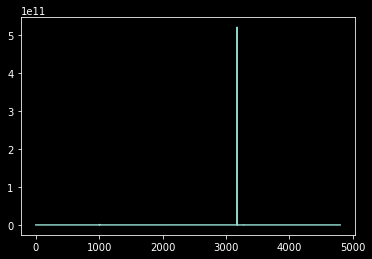

In [50]:
plt.plot(radius_curv[:,1])

In [43]:
print(p1,p2,p0)
a = np.linalg.norm(p1-p2)
b = np.linalg.norm(p0-p1)
c = np.linalg.norm(p0-p2)
radius = (a*b*c/2)/np.linalg.norm(d)
print(a,b,c)
print(radius)

[  0.         511.03275762 177.36      ] [  0. 514. 163.] [  0.         512.84893632 170.18      ]
14.663360028538106 7.406139687479336 7.2716812079095305
82.68163022281


Text(0.5, 0, 'Time')

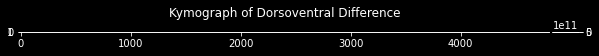

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(10,10))
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = 15 # pad is in points...
ax = plt.gca()

im = plt.imshow(radius_curv.swapaxes(0,1), cmap='bwr',origin='lower')
plt.title("Kymograph of Dorsoventral Difference")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax)
plt.xlabel('Time')

In [15]:
##Combining both coordinate interpolation with boxes
select_coords =[]
layer_boxes = []
i=0
n_interpol = 5
for k in range(len(sk_skeleton)):
    coords =sk_skeleton[k].path_coordinates(0)
    interp_coord = au.interpolate_skeleton(coords,n_interpol)
    for c_num in range(interp_coord.shape[0]):
        select_coords.append([k,i,interp_coord[c_num,1],interp_coord[c_num,2]])
        if c_num<(interp_coord.shape[0]-1):
            left_box, right_box  = au.create_skeleton_box(interp_coord[c_num,1:], interp_coord[c_num+1,1:],side='LR',width=100)
            two_column = np.zeros((4,2))
            left_box = np.hstack((two_column,left_box))
            right_box = np.hstack((two_column,right_box))
            left_box[:,0]= k
            right_box[:,0]=k
            layer_boxes.append([left_box , right_box])
select_coords=np.array(select_coords)
layer_boxes = np.array(layer_boxes)
#Plot skeleton interpolation points
viewer.add_points(select_coords, name= 'interpol' , face_color='cornflowerblue')
##Plot the L and R boxes
viewer.add_shapes(layer_boxes[:,0] ,name='ventral' ,face_color='cyan') # Left boxes
viewer.add_shapes(layer_boxes[:,1],name= 'dorsal',face_color='orange') # Right boxes

<Shapes layer 'dorsal' at 0x2191822e400>

### Testing the box cutouts

In [26]:

def crop_rot_rect(img , rect):
    # https://stackoverflow.com/questions/37177811/crop-rectangle-returned-by-minarearect-opencv-python
    import cv2
    rect = np.int0(rect)
    rect = rect[:,[1,0]]
 
    # for debugging
    # cv2.drawContours(img,[rect], 0, (0, 255, 0), 5)

    rect = cv2.minAreaRect(rect)
    center, size, angle = rect[0], rect[1], rect[2]
    center, size = tuple(map(int, center)), tuple(map(int, size[::-1]))
    print("center1 {}".format(center))
    print("size1: {}".format(size))
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    print(box)

    w = rect[1][0]
    h = rect[1][1]

    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)

    rotated = False
    if angle < -45:
        angle+=90
        rotated = True
        
    size = (int((x2-x1)),int((y2-y1)))

    # cv2.circle(img, center, 10, (0,255,0), -1) #again this was mostly for debugging purposes
    # plt.figure(figsize=(10,10))
    # plt.imshow(img,cmap='gray')

    # M = cv2.getRotationMatrix2D(center, angle, 1.0)
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)
    cropped = cv2.getRectSubPix(img, size, center)    
    cropped = cv2.warpAffine(cropped, M, size)

    croppedW = w if not rotated else h
    croppedH = h if not rotated else w

    croppedRotated = cv2.getRectSubPix(cropped, (int(croppedW), int(croppedH)), (size[0]/2, size[1]/2))

    # plt.figure(figsize=(10,10))
    # plt.imshow(croppedRotated)


In [218]:
"""
Crop out the tilted ROIs generated to measure the ventral and dorsal sides

# https://stackoverflow.com/questions/11627362/how-to-straighten-a-rotated-rectangle-area-of-an-image-using-opencv-in-python/48553593#48553593

    @Parameters:
    rect (y,x) = coordinates of corners of ROI
    src (y,x) =image in 8 bit or float 32

"""

def getSubImage(rect, src):
    rect = np.int0(rect)
    rect = rect[:,[1,0]]
    rect = cv2.minAreaRect(rect)

    # Get center, size, and angle from rect
    center, size, theta = rect
    # Convert to int 
    center, size = tuple(map(int, center)), tuple(map(int, size))
    # Get rotation matrix for rectangle
    M = cv2.getRotationMatrix2D( center, theta, 1)
    # Perform rotation on src image
    dst = cv2.warpAffine(src.astype(np.float32), M, src.shape[:2])
    out = cv2.getRectSubPix(dst, size, center)
    return out


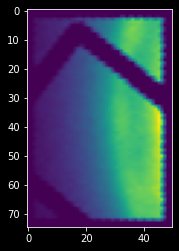

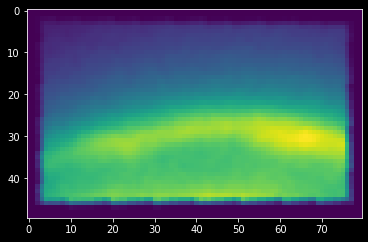

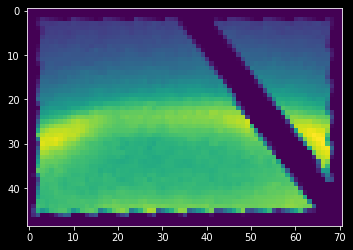

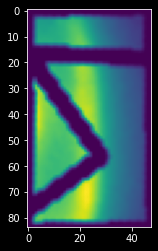

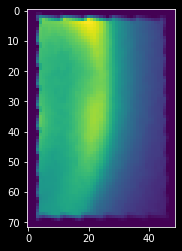

In [219]:
import cv2
t,c,y,x = crop_stack.shape
r_ventral = np.zeros((t,n_interpol,3))
r_dorsal = np.zeros((t,n_interpol,3))
ventral = layer_boxes[:,0]
dorsal = layer_boxes[:,1]
nbox,_,_ = ventral.shape

for v in range(5):
    img = crop_stack[int(ventral[v,0,0]),0]
    rect= ventral[v,:,2:]
    # print("coords: {}".format(rect))
    roi = getSubImage(rect,img)
    plt.figure()
    plt.imshow(roi)
# plt.figure(figsize=(10,10))
# plt.imshow(img)


In [147]:
import cv2
t,c,y,x = crop_stack.shape
r_ventral = np.zeros((t,n_interpol,3))
r_dorsal = np.zeros((t,n_interpol,3))
ventral = layer_boxes[:,0]
dorsal = layer_boxes[:,1]
nbox,_,_ = ventral.shape
print(ventral.shape)
print(ventral[2,:,2:])
print(nbox)
print(crop_stack.shape)

for v in range(4):
    img = crop_stack[int(ventral[v,0,0]),0]
    rect= ventral[v,:,2:]
    rect = cv2.minAreaRect(rect.astype(int))
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img, [box], 0, (0,255,0), 2) # this was mostly for debugging you may omit
    Ys = [i[0] for i in box]
    Xs = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)
    W =int(rect[1][0])
    H =int(rect[1][1])
    rotated = False
    angle = rect[2]
    if angle < -45:
        angle+=90
        rotated = True

    size = (int((x2-x1)),int((y2-y1)))
    cv2.circle(img, center, -1, (0,255,0), -1) #again this was mostly for debugging purposes
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)

    cropped = cv2.getRectSubPix(np.float32(img), size, center)    
    cropped = cv2.warpAffine(cropped, M, size)


    croppedW = W if not rotated else H 
    croppedH = H if not rotated else W

    croppedRotated = cv2.getRectSubPix(cropped, (int(croppedW), int(croppedH)), (size[0]/2, size[1]/2))
    plt.figure()
    plt.imshow(croppedRotated,cmap='gray')
    # height,width = img.shape[0],img.shape[1]
    # Perform rotation on src image
    # img_rot = cv2.warpAffine(img, M,(width,height))
    # # plt.figure()
    # # plt.imshow(img_rot)
    # out = cv2.getRectSubPix(np.float32(img_rot), size, center)
img=wo.im_bit_convert(img,bit=8,norm=True)
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
# plt.close()

(500, 4, 4)
[[218.         291.        ]
 [289.         301.        ]
 [282.02657413 350.51132584]
 [211.02657413 340.51132584]]
500
(100, 1, 608, 608)


error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type


In [ ]:
t,c,y,x = crop_stack.shape
r_ventral = np.zeros((t,n_interpol,3))
r_dorsal = np.zeros((t,n_interpol,3))
ventral = layer_boxes[:,0]
dorsal = layer_boxes[:,1]
nbox,_,_ = ventral.shape
top_percent= 0.8  #top percent of the pixels

roi_vStack = []

for v in range(nbox):
    img_tp = int(ventral[v,0,0])
    roi_v = crop_rot_rect(crop_stack[img_tp,0],ventral[v,:,2:])
    roi_vStack.append([roi_v])
    roi_vf= roi_v.flatten()
    #taking only 50-80% of the pixels to prevent artifacts from hitting the edge or deformation of muscle
    idx =round(roi_v.size*top_percent)
    ft_v= roi_vf[roi_vf.argsort()[-idx:]].mean()

    roi_d = crop_rot_rect(crop_stack[img_tp,0],dorsal[v,:,2:])
    roi_df= roi_d.flatten()
    #taking only 50-80% of the pixels to prevent artifacts from hitting the edge or deformation of muscle
    idx =round(roi_d.size*top_percent)
    ft_d= roi_df[roi_df.argsort()[-idx:]].mean()

    
    box_num =v%n_interpol
    r_ventral[img_tp,box_num,0]  = ft_v
    r_ventral[img_tp,box_num,1] = 0
    r_ventral[img_tp,box_num,2] = 0

    r_dorsal[img_tp,box_num,0]  = ft_d
    r_dorsal[img_tp,box_num,1] = 0
    r_dorsal[img_tp,box_num,2] = 0



In [ ]:
## THis produces the wrong box shape. WHen boxes are tilted we need to do a rotation matrix from center of rectangle to crop the main image.

# t,c,y,x = crop_stack.shape
# r_ventral = np.zeros((t,n_interpol,3))
# r_dorsal = np.zeros((t,n_interpol,3))
# ventral = layer_boxes[:,0]
# dorsal = layer_boxes[:,1]
# nbox,_,_ = ventral.shape
# top_percent= 0.8  #top percent of the pixels

# for v in range(nbox):
#     img_tp = int(ventral[v,0,0])
#     min_val,max_val = au.create_box(ventral[v,:,2:])
#     roi_v = crop_stack[img_tp ,0, min_val[0]:max_val[0], min_val[1]: max_val[1]]
#     roi_vf= roi_v.flatten()
#     #taking only 50-80% of the pixels to prevent artifacts from hitting the edge or deformation of muscle
#     idx =round(roi_v.size*top_percent)
#     ft_v= roi_vf[roi_vf.argsort()[-idx:]].mean()

#     min_val,max_val = au.create_box(dorsal[v,:,2:])
#     roi_d = crop_stack[img_tp ,0, min_val[0]:max_val[0], min_val[1]: max_val[1]]
#     roi_df= roi_d.flatten()
#     #taking only 50-80% of the pixels to prevent artifacts from hitting the edge or deformation of muscle
#     idx =round(roi_d.size*top_percent)
#     ft_d= roi_df[roi_df.argsort()[-idx:]].mean()

    
#     box_num =v%n_interpol
#     r_ventral[img_tp,box_num,0]  = ft_v
#     r_ventral[img_tp,box_num,1] = 0
#     r_ventral[img_tp,box_num,2] = 0

#     r_dorsal[img_tp,box_num,0]  = ft_d
#     r_dorsal[img_tp,box_num,1] = 0
#     r_dorsal[img_tp,box_num,2] = 0



In [ ]:

t,c,y,x = crop_stack.shape
ventral = layer_boxes[:,0]
nbox,_,_ = ventral.shape
f_median = np.zeros((nbox,2))
print(nbox)
#Get the Medians
for v in range(nbox):
    box_num =v%n_interpol
    f_median[v,0] = np.median(r_ventral[:,box_num,0])
    f_median[v,1] = np.median(r_dorsal[:,box_num,0])

# f_median.reshape(110,50,1)
#Normalize the plots Fmean/Fmedian
dorsoventral_diff = np.zeros((t,n_interpol))
for v in range(nbox):
    img_tp = int(ventral[v,0,0])
    box_num =v%n_interpol
    r_ventral[img_tp,box_num,2] =r_ventral[img_tp,box_num,0] /f_median[v,0]
    r_dorsal[img_tp,box_num,2] =r_dorsal[img_tp,box_num,0] /f_median[v,1]
    dorsoventral_diff[img_tp,box_num]= r_dorsal[img_tp,box_num,2] -r_ventral[img_tp,box_num,2]

5000


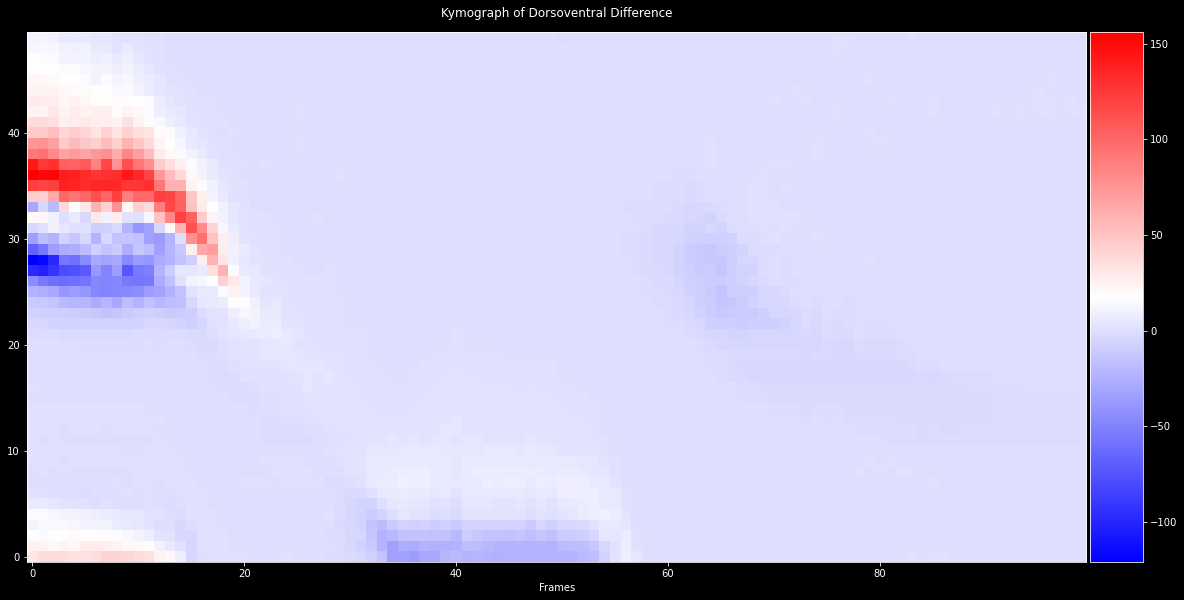

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(20,10))
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = 15 # pad is in points...
ax = plt.gca()

im = plt.imshow(dorsoventral_diff.swapaxes(0,1), cmap='bwr',origin='lower')
plt.title("Kymograph of Dorsoventral Difference")
plt.xlabel('Frames') 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax)


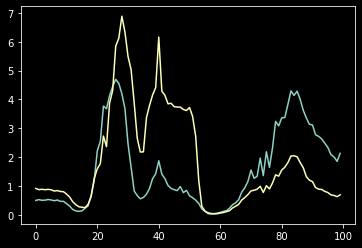

In [76]:
plt.plot(r_ventral[:,13,2])
plt.plot(r_dorsal[:,13,2])

In [24]:
plt.figure(figsize=(15,10))
i=2 # normalized deltaF/F
box_id = 100

plt.plot(r_ventral[:,box_id,i], label='ventral', linestyle='-',color='cyan')
plt.plot(r_dorsal[:,box_id,i], label='dorsal', linestyle=':',color='orange')
plt.legend()
# plt.axvline(x=34, color='r', label='axvline - full height')
# plt.vlines(x=[34, 70], ymin=7500, ymax=18000, colors='purple', ls='--', lw=2, label='vline_multiple - full height')

plt.title('Dorsal vs Ventral')
plt.xlabel('Frame')
plt.ylabel('Intensity')
plt.show()

IndexError: index 100 is out of bounds for axis 1 with size 30

<Figure size 1080x720 with 0 Axes>

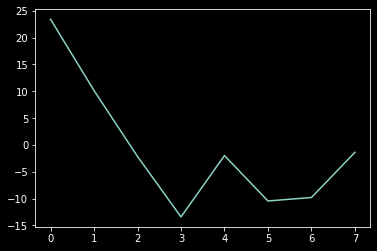

In [29]:
coords =sk_skeleton[35].path_coordinates(0)
new_skeleton = au.interpolate_skeleton(coords, 10)
skel_x = new_skeleton[:, 1]
skel_y = new_skeleton[:, 2]
bends =[]
for i in range(2,len(skel_x)-1):
    a = [skel_x[i-1]-skel_x[i], skel_y[i-1]-skel_y[i]]
    b = [skel_x[i+1]-skel_x[i], skel_y[i+1]-skel_y[i]]
    angle= np.arcsin(np.cross(a,b)/np.linalg.norm(a)/np.linalg.norm(b))*180/np.pi
    bends.append(angle)
plt.plot(bends)

In [188]:
nbox,_,_ = ventral.shape
# n_interpol =50
roi_plt_ventral = np.reshape(ventral,(int(nbox/n_interpol),n_interpol,4,4))
roi_plt_ventral[:,0:50:5,:,:].shape
viewer.add_shapes(roi_plt_ventral[:,0,], label='ROI 0 ', face_color='cyan')

<Shapes layer 'Shapes [1]' at 0x1d723274070>

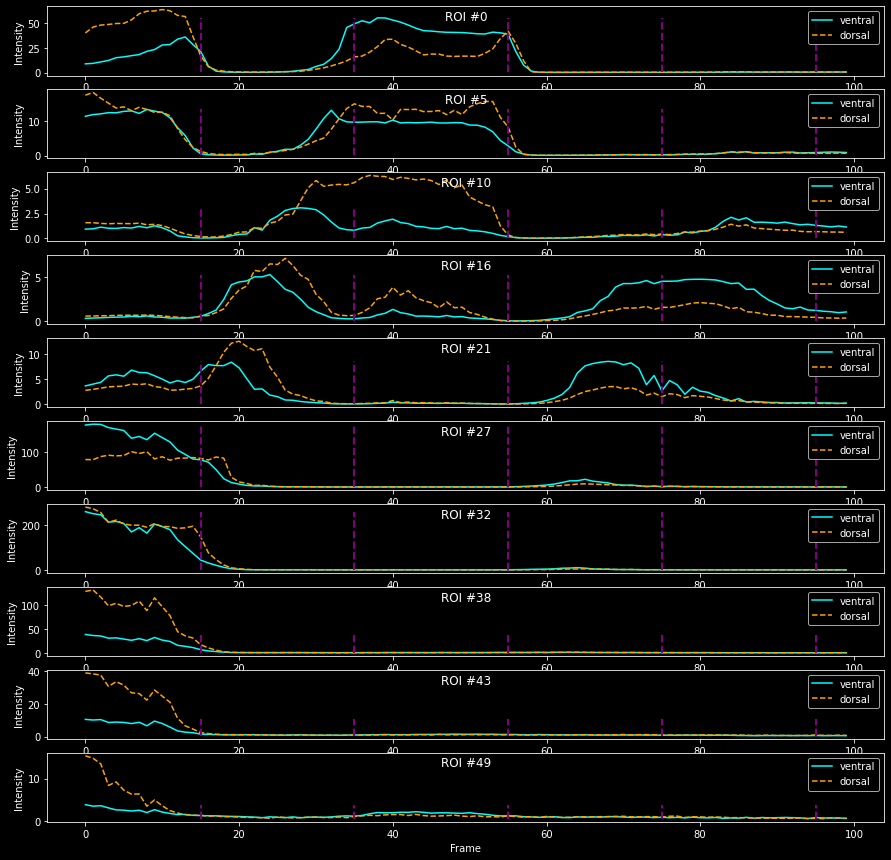

In [77]:
#Plotting Interpolated Points Intensity and Angle for different timepoints
n=20
s=2 
box_id = 10
k=0
n_pt =10
# n_interpol =50
pt_list =np.linspace(0,n_interpol-1,10).astype(int)
f_list = [15,35,55,75,95]


roi_plt_ventral = np.reshape(ventral,(int(nbox/n_interpol),n_interpol,4,4))
roi_plt_dorsal= np.reshape(dorsal,(int(nbox/n_interpol),n_interpol,4,4))
# print(pt_list)
# fig, axs = plt.subplots(nrows=2, ncols=1,sharey=True, figsize=(5,3))
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
fig, axs = plt.subplots(nrows=n_pt, ncols=1, figsize=(15,15))
for i, n_pt in enumerate(pt_list):
    coords =sk_skeleton[n_pt].path_coordinates(0)
    angles  = au.skeleton_to_angle(coords,theta_dims=n_interpol)
    axs[i].plot(r_ventral[:,n_pt,s], label='ventral', linestyle='-',color='cyan')
    axs[i].plot(r_dorsal[:,n_pt,s], label='dorsal', linestyle='--',color='orange')
    axs[i].legend(loc='upper right')
    axs[i].set_title('ROI #{}'.format(n_pt))
    axs[i].set_ylabel('Intensity')
    axs[i].set_xlabel('Frame')
    axs[i].vlines(x=f_list, ymin=r_ventral[:,n_pt,s].min(), ymax=r_ventral[:,n_pt,s].max(), colors='purple', ls='--', lw=2, label='vline_multiple - full height')
    
    
    
    viewer.add_shapes(roi_plt_ventral[:,n_pt,], name='ROI {} '.format(n_pt), face_color='cyan')
    viewer.add_shapes(roi_plt_dorsal[:,n_pt,], name='ROI {} '.format(n_pt), face_color='orange')


Text(0.5, 0.98, 'Right vs Left Box')

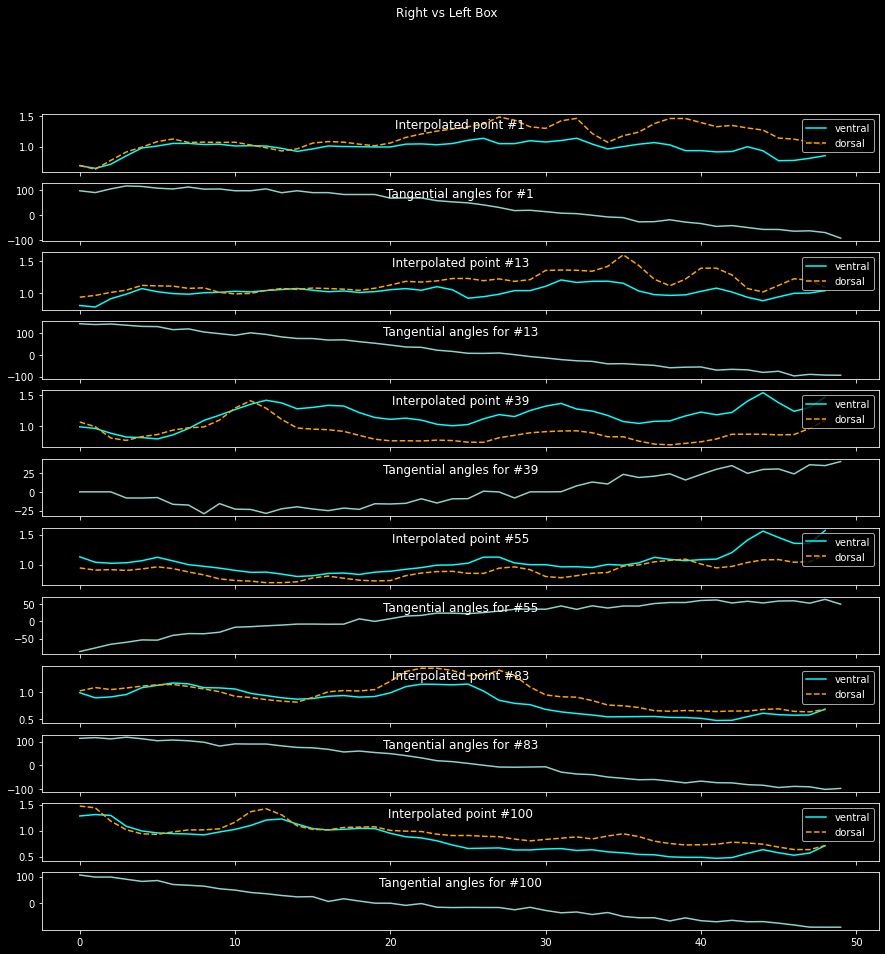

In [193]:
#Plotting Interpolated Points Intensity and Angle for different timepoints
n=20
s=2 #0-mean,1,max,2 sum
box_id = 10
k=0
n=12

coords =sk_skeleton[k].path_coordinates(0)
angles  = skeleton_to_angle(coords,theta_dims=n_interpol)
# fig, axs = plt.subplots(nrows=2, ncols=1,sharex=True,constrained_layout=True, figsize=(5,3))
fig, axs = plt.subplots(nrows=n, ncols=1,sharex=True, figsize=(15,15))
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -14  # pad is in points...

for i,tp in enumerate([1,13,39,55,83,100]):
    coords =sk_skeleton[tp].path_coordinates(0)
    angles  = skeleton_to_angle(coords,theta_dims=50)
    axs[i*2].plot(r_ventral[tp,:49,s], label='ventral', linestyle='-',color='cyan')
    # axs[i*2].plot(r_ventral[tp,:49,1], label='max_ventral', linestyle='-',color='yellow')
    # axs[i*2].plot(r_dorsal[tp,:49,1], label='max_dorsal', linestyle='--',color='white')
    axs[i*2].plot(r_dorsal[tp,:49,s], label='dorsal', linestyle='--',color='orange')
    axs[i*2].legend(loc='upper right')
    axs[i*2].set_title('Interpolated point #{}'.format(tp))
    axs[(i*2)+1].plot(angles)
    axs[(i*2)+1].set_title('Tangential angles for #{}'.format(tp))
    # axs[tp*2].set_title('Timepoint {}'.format(tp))

fig.suptitle("Right vs Left Box")


# plt.figure(figsize=(5,5))
# plt.plot(angles)
# plt.title("Worm Angles")
# plt.xlabel("Worm Body Point")
# plt.ylabel("Body Curvature [deg]")

# distance =[]
# for i in range(angles.size-1):
#     distance.append(angle_distance(angles[i],angles[i+1]))
# print(distance)

<Figure size 1440x1440 with 0 Axes>

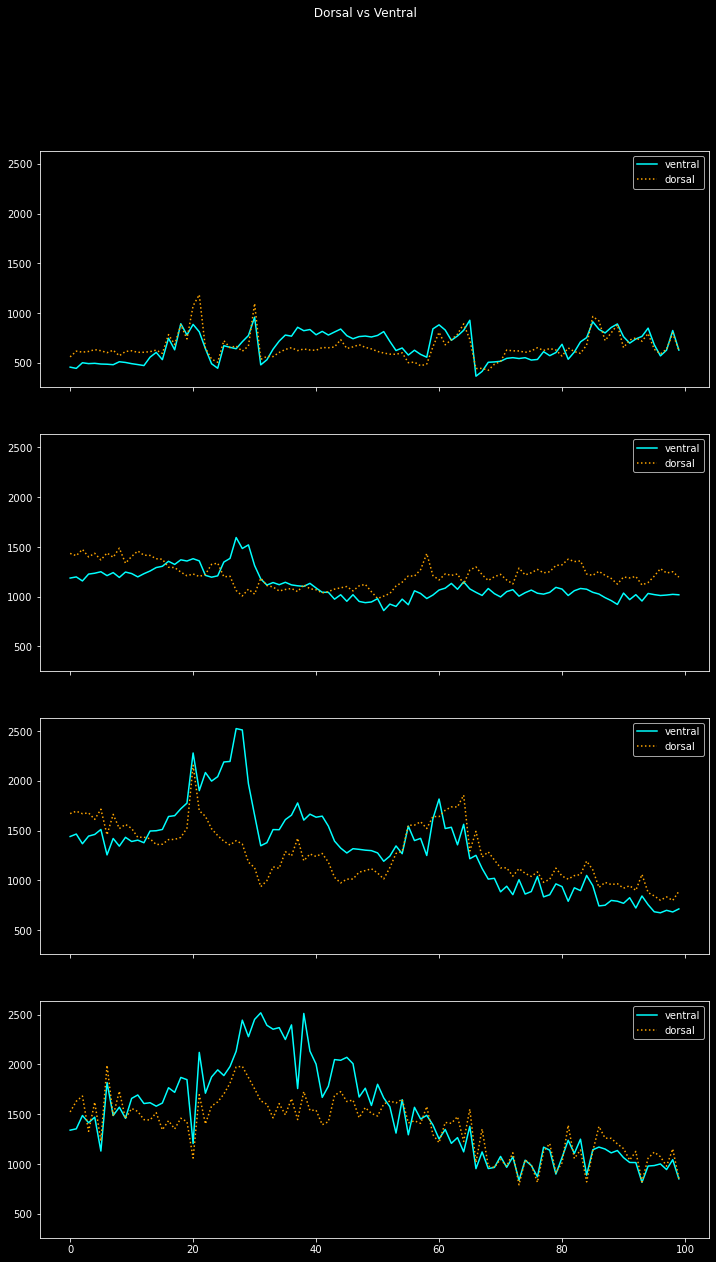

In [236]:
plt.rcParams['figure.figsize'] = [12, 20]
plt.figure(figsize=(20,20))
n=4
fig ,axs = plt.subplots(n,sharex=True,sharey=True)
fig.suptitle(" Dorsal vs Ventral")
s=0 #0-mean,1,max,2 sum
box_id = 10
for i,val in enumerate(np.linspace(0,49,n,dtype=np.uint8)):
    axs[i].plot(r_ventral[:,val,s], label='ventral', linestyle='-',color='cyan')
    axs[i].plot(r_dorsal[:,val,s], label='dorsal', linestyle=':',color='orange')
    axs[i].legend(loc='upper right')

# fig.show()

In [124]:
from skimage.measure import label, regionprops_table

label_img = 
#Create properties dictionary
properties = regionprops_table( 
    properties =('bbox', 'perimeter')
)
# properties['normalized'] = properties['mean']/properties['mean']


TypeError: regionprops_table() missing 1 required positional argument: 'label_image'

In [215]:
# from skimage.filters import threshold_otsu, threshold_yen

# thresh_otsu = threshold_otsu(crop_stack_gauss)
# #Ended up tunning the threshold to a higher value
# binary_stack = crop_stack_gauss > 660
# print(thresh_otsu)
# plt.hist(crop_stack_gauss.ravel(), bins=256)
# plt.title('Histogram')
# plt.axvline(thresh_otsu, color='r')
# viewer.add_image(binary_stack)

In [162]:
from scipy.interpolate import interp1d
def interpolate_skeleton(skeleton: np.ndarray, new_dims: int) -> np.ndarray:
    """
    Interpolates a worm skeleton to have a different number of points
    """
    new_pos_dim = []
    for dim in range(skeleton.shape[1]):
        y = skeleton[:, dim]
        x = np.arange(y.size)
        if np.any(np.isnan(y)):
            new_pos_dim.append([np.nan] * (new_dims + 1))
        else:
            # Interpolate the data using a cubic spline to "new_length" samples
            new_length = new_dims + 1
            new_x = np.linspace(x.min(), x.max(), new_length)
            new_y = interp1d(x, y, kind="cubic")(new_x)
            new_pos_dim.append(new_y)
    new_pos = np.vstack(new_pos_dim).T
    return new_pos
    
def skeletons_to_angles(skeletons: np.ndarray, theta_dims: int) -> np.ndarray:
    new_skeletons = []
    for frame in range(skeletons.shape[0]):
        skeleton = skeletons[frame]
        new_skeletons.append(interpolate_skeleton(skeleton, theta_dims))
    new_skeletons = np.array(new_skeletons, skeletons.dtype)

    skel_x = new_skeletons[:, :, 0]
    skel_y = new_skeletons[:, :, 1]
    d_x = np.diff(skel_x, axis=1)
    d_y = np.diff(skel_y, axis=1)
    # calculate tangent angles.  atan2 uses angles from -pi to pi
    angles = np.arctan2(d_y, d_x)
    return angles.astype(np.float32)

def skeleton_to_angle(skeleton: np.ndarray, theta_dims: int):
    new_skeleton = interpolate_skeleton(skeleton, theta_dims)
    skel_x = new_skeleton[:, 1]
    skel_y = new_skeleton[:, 2]
    d_x = np.diff(skel_x)
    d_y = np.diff(skel_y)
    # calculate tangent angles.  atan2 uses angles from -pi to pi
    angles = np.arctan2(d_y, d_x)
    angles=np.degrees(angles)
    return angles.astype(np.float32)
    
def angle_distance(theta_a: np.ndarray, theta_b: np.ndarray) -> float:
    """
    Angle distance that takes into account the periodicity of angles
    """
    diff = np.abs(np.arctan2(np.sin(theta_a - theta_b), np.cos(theta_a - theta_b)))
    return diff.mean()

def skeleton_bends(skeleton: np.ndarray, theta_dims: int):
    new_skeleton = interpolate_skeleton(skeleton, theta_dims)
    skel_x = new_skeleton[:, 1]
    skel_y = new_skeleton[:, 2]
    bends =[]
    for i in range(2,len(skel_x)-1):
        a = [skel_x[i-1]-skel_x[i], skel_y[i-1]-skel_y[i]]
        b = [skel_x[i+1]-skel_x[i], skel_y[i+1]-skel_y[i]]
        angle= np.arcsin(np.cross(a,b)/np.mag(a)/np.mag(b))*180/np.pi
        bends.appends(angle)
    return bends


Text(0, 0.5, 'Body Curvature [deg]')

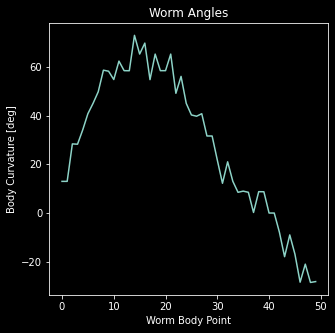

In [110]:
k=70
n_interpol=50

coords =sk_skeleton[k].path_coordinates(0)
new_skeleton = interpolate_skeleton(coords, n_interpol)
skel_x = new_skeleton[:, 1]
skel_y = new_skeleton[:, 2]
d_x = np.diff(skel_x)
d_y = np.diff(skel_y)
angles = np.arctan2(d_y, d_x)
angles=np.degrees(angles)
# angles = angles.astype(np.float32)

distance =[]
for i in range(angles.size-1):
    distance.append(angle_distance(angles[i],angles[i+1]))
distance = np.array(distance)

plt.figure(figsize=(5,5))
plt.plot(angles)
# plt.scatter(distance/distance.max(),angles[:n_interpol-1])
plt.title("Worm Angles")
plt.xlabel("Worm Body Point")
plt.ylabel("Body Curvature [deg]")


# print(distance)

## CONTOUR

(1, 1135, 2)
0


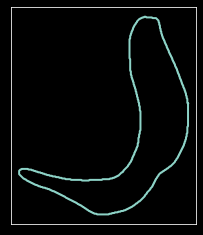

In [9]:
i=14
contours=find_contours(binary_stack_filled[i,0],0.3)
print(np.array(contours).shape)
# Display the image and plot all contours found
fig, ax = plt.subplots()
# ax.imshow(contours_stack[i], interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    print(n)
    ax.plot(contour[:, 0], contour[:, 1], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [10]:
#Get the stack contours
t,z,y,x =binary_stack_filled.shape
print(binary_stack_filled.shape)
contour_coords =[]
for i in range(t):
    contours = find_contours(binary_stack_filled[i,0],0.8)
    contours= np.array(contours)
    # print(contours.shape)
    for n in range(contours.shape[1]):
        contour_coords.append([i,contours[0,n,0], contours[0,n,1]])

    # contour_coords.append(np.array(contour))
    # for k in range(contour.shape[0]):
    #     contour_coords[i,:,:] = np.array([0,i,contour[k,0],contour[k,1]])
contour_coords=np.array(contour_coords)
viewer.add_points(contour_coords,edge_color='blue')

(140, 1, 608, 608)


<Points layer 'contour_coords' at 0x177f7c120a0>

In [11]:
#Interpolate Contour
contour_interp=[]
t,c,y,x = crop_stack.shape
j=0 #replace this when we do for all stack
for k in range(t):
    contours = find_contours(binary_stack_filled[k,0],0.8)
    countours=np.array(contours)
    inter_cont_coord = au.interpolate_skeleton(contours[0],50)
    for c_num in range(inter_cont_coord.shape[0]):
        contour_interp.append([k,j,inter_cont_coord[c_num,0],inter_cont_coord[c_num,1]])
contour_interp=np.array(contour_interp)
viewer.add_points(contour_interp, face_color='cornflowerblue')

<Points layer 'contour_interp' at 0x177f78a1bb0>

In [12]:
#Plot Boxes
i=3
bbbox_cont= au.create_skeleton_box(contour_interp[i,2:], contour_interp[i+1,2:],side='center',width=30)
min_val = bbbox_cont.min(axis=0)
max_val = bbbox_cont.max(axis=0)
tl = np.array([min_val[0], min_val[1]])
br = np.array([max_val[0], max_val[1]])
img_box = np.round(np.array([tl, br])).astype(int)
z = np.zeros((2,2)).astype(int)
img_box = np.hstack((z,img_box)).astype(int)

viewer.add_shapes(bbbox_cont)

<Shapes layer 'bbbox_cont' at 0x177f8c73c10>

In [228]:
# print(crop_stack.shape)
# n_interpol =50
# interpol_coords =[]
# interpol_boxes = []
# contour_interp =[]
# t,c,y,x = crop_stack.shape
# for k in range(t):
#     contours = find_contours(binary_stack_filled[k,0],0.8)
#     countours=np.array(contours)
#     inter_cont_coord = au.interpolate_skeleton(contours[0],n_interpol)
#     for c_num in range(inter_cont_coord.shape[0]):
#         contour_interp.append([k,j,inter_cont_coord[c_num,0],inter_cont_coord[c_num,1]])
#         if c_num <(inter_cont_coord.shape[0]-1):
#             bbox = au.create_skeleton_box(inter_cont_coord[c_num], inter_cont_coord[c_num+1],side='center',width=30)
#             two_column = np.zeros((4,2))
#             bbox = np.hstack((two_column,bbox))
#             bbox[:,0]=k
#             # print( bbox[:,1])
#             interpol_boxes.append([bbox])
# interpol_boxes = np.array(interpol_boxes)
# contour_interp=np.array(contour_interp)
# interpol_boxes = np.squeeze(interpol_boxes, axis=1)
# print(interpol_boxes.shape)
# viewer.add_shapes(interpol_boxes,face_color='blue') # Left boxes

In [61]:
##Combining both coordinate interpolation with boxes
select_coords =[]
layer_boxes = []
n_interpol = 30
for k in range(contour_interp.shape[0]):
    coords =sk_skeleton[k].path_coordinates(0)
    interp_coord = interpolate_skeleton(coords,n_interpol)
    for c_num in range(interp_coord.shape[0]):
        select_coords.append([k,interp_coord[c_num,0],interp_coord[c_num,1]])
        if c_num<(interp_coord.shape[0]-1):
            left_box, right_box  = au.create_skeleton_box(contour_interp[i,2:], contour_interp[i+1,2:],side='center',width=30)
            two_column = np.zeros((4,2))
            left_box = np.hstack((two_column,left_box))
            right_box = np.hstack((two_column,right_box))
            left_box[:,1]= k
            right_box[:,1]=k
            layer_boxes.append([left_box , right_box])
select_coords=np.array(select_coords)
layer_boxes = np.array(layer_boxes)
#Plot skeleton interpolation points
viewer.add_points(select_coords, face_color='cornflowerblue')
##Plot the L and R boxes
viewer.add_shapes(layer_boxes[:,0]  ,face_color='blue') # Left boxes
viewer.add_shapes(layer_boxes[:,1],face_color='red') # Right boxes


NameError: name 'sk_skeleton' is not defined

(140, 1, 608, 608)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(-0.5, 607.5, 607.5, -0.5)

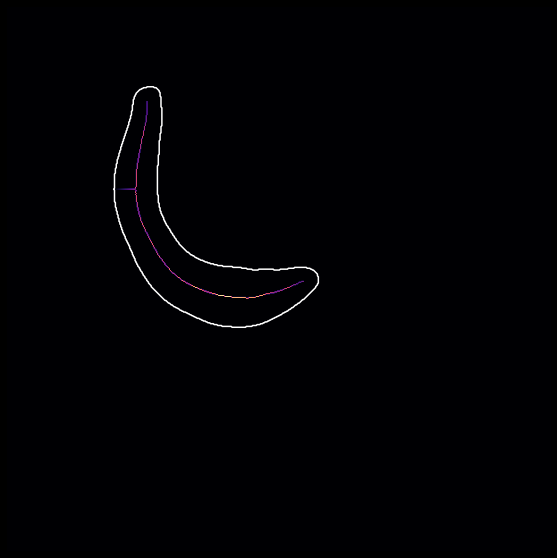

In [41]:
from skimage.morphology import medial_axis
print(binary_stack.shape)
binary_stack_filled3d = np.squeeze(binary_stack)
skel, distance = medial_axis(binary_stack_filled3d[1], return_distance=True)
# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel
print(dist_on_skel)
plt.figure(figsize=(10,10))
plt.imshow(dist_on_skel, cmap='magma')
plt.contour(binary_stack_filled3d[1], [0.5], colors='w')
plt.axis('off')

In [129]:
# perform skeletonization
skeleton =np.array([skeletonize(binary_stack_filled3d[i]) for i in range(binary_stack_filled3d.shape[0])])
print(skeleton.shape)
viewer.add_image(skeleton, colormap='magenta', blending='additive')

(140, 608, 608)


<Image layer 'skeleton [1]' at 0x25736ec2730>

In [130]:
from skan import Skeleton
sk_skeleton =[Skeleton(skeleton[i]) for i in range(skeleton.shape[0])]

In [132]:
# Finding the points where we have start/ends
end_points =[]
for k in range(len(sk_skeleton)):
    for i, val in enumerate(sk_skeleton[k].coordinates[sk_skeleton[k].degrees == 1]):
      end_points.append([k,val[0],val[1]])

np_endPoint = np.array(end_points)
print(np_endPoint.shape)
viewer.add_points(np_endPoint, face_color='cornflowerblue')


(316, 3)


<Points layer 'np_endPoint [1]' at 0x2573a289880>

In [376]:
i=3
bbbox_cont= create_skeleton_box(contour_interp[i,1:], contour_interp[i+1,1:],side='center',width=30)
min_val = bbbox_cont.min(axis=0)
max_val = bbbox_cont.max(axis=0)
tl = np.array([min_val[0], min_val[1]])
br = np.array([max_val[0], max_val[1]])
img_box = np.round(np.array([tl, br])).astype(int)
z = np.zeros((2,2)).astype(int)
img_box = np.hstack((z,img_box)).astype(int)

viewer.add_shapes(bbbox_cont)

<Shapes layer 'bbbox_cont' at 0x257428bfa90>

In [360]:
select_coords =[]
for k in range(len(sk_skeleton)):
    coords =sk_skeleton[k].path_coordinates(0)
    interp_coord = interpolate_skeleton(coords,50)
    for c_num in range(interp_coord.shape[0]):
        select_coords.append([k,interp_coord[c_num,0],interp_coord[c_num,1]])
select_coords=np.array(select_coords)
viewer.add_points(select_coords, face_color='cornflowerblue')

ValueError: The number of derivatives at boundaries does not match: expected 1, got 0+0

In [321]:
"""
Refresh on vector calc
https://stackoverflow.com/questions/7469959/given-2-points-how-do-i-draw-a-line-at-a-right-angle-to-the-line-formed-by-the-t/7470098#7470098
The matrix representation of 2D transformation:
x' = xcos(t) - ysin(t)
y' = xsin(t)  - ycost(t)

so if t =90 deg then 
x'=-y
y'= x

then normals to line segment would be:
(-dy,dx)(dy,-dx)

"""
width = 100
skel_perp = np.empty((2,), dtype=np.float32)

perp_line = [-(coord_b[1]-coord_a[1]), coord_b[0]-coord_a[0]]
# Take the magnitude to get the length of the vector 
norm = np.sqrt(perp_line[0]*perp_line[0]+perp_line[1]*perp_line[1])

skel_perp[0] = (perp_line[0] / norm) * (width / 2)
skel_perp[1] = (perp_line[1] / norm) * (width / 2)

##Box origin is 'lower' instead of upper
bot_l = coord_a + skel_perp
top_l = coord_b + skel_perp
top_r = coord_b - skel_perp # 
bot_r = coord_a - skel_perp # 

bbox_rect = np.array(
    [bot_l, top_l, top_r, bot_r]
)


NameError: name 'coord_b' is not defined

In [470]:
#Plotting left and right boxes
width = 50
skel_perp = np.empty((2,), dtype=np.float32)

perp_line = [-(coord_b[1]-coord_a[1]), coord_b[0]-coord_a[0]]
# Take the magnitude to get the length of the vector 
norm = np.sqrt(perp_line[0]*perp_line[0]+perp_line[1]*perp_line[1])

#Normal to skeleton
skel_perp[0] = (perp_line[0] / norm) * (width / 2)
skel_perp[1] = (perp_line[1] / norm) * (width / 2)
# skel_perp[1] = (perp_line[1] / norm) 

##Box origin is 'lower' instead of upper
bot_l = coord_a + skel_perp
top_l = coord_b + skel_perp
top_r = coord_b - skel_perp # 
bot_r = coord_a - skel_perp # 

bbox_rect_left = np.array(
    [coord_a, coord_b, top_l, bot_l]
)

bbox_rect_right = np.array(
    [coord_a, coord_b, top_r, bot_r]
)

In [352]:
#Make the skeleton Points
select_coords =[]
for k in range(len(sk_skeleton)):
    coords =sk_skeleton[k].path_coordinates(0)
    interp_coord = interpolate_skeleton(coords,50)
    for c_num in range(interp_coord.shape[0]):
        select_coords.append([k,interp_coord[c_num,0],interp_coord[c_num,1]])
select_coords=np.array(select_coords)
viewer.add_points(select_coords, face_color='cornflowerblue')

ValueError: The number of derivatives at boundaries does not match: expected 1, got 0+0

In [334]:
i=0
left_box, right_box  = create_skeleton_box(interp_coord[i], interp_coord[i+1],side='LR',width=50)
a = np.array([left_box , right_box])
print(a)
print(left_box.shape)
z = np.zeros((4,2))
left_box = np.hstack((z,left_box))
left_box[:,1]= 1
print(z)
print(left_box.shape)
print(left_box)

[[[ 69.         209.        ]
  [137.8        197.01114666]
  [146.3834837  246.26887524]
  [ 77.5834837  258.25772858]]

 [[ 69.         209.        ]
  [137.8        197.01114666]
  [129.2165163  147.75341808]
  [ 60.4165163  159.74227142]]]
(4, 2)
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
(4, 4)
[[  0.           1.          69.         209.        ]
 [  0.           1.         137.8        197.01114666]
 [  0.           1.         146.3834837  246.26887524]
 [  0.           1.          77.5834837  258.25772858]]


In [140]:
k=0
layer_boxes = []
coords =sk_skeleton[k].path_coordinates(0)
interp_coord = interpolate_skeleton(coords,50)
for i in range(interp_coord.shape[0]-1):
    left_box, right_box  = create_skeleton_box(interp_coord[i], interp_coord[i+1],side='LR',width=50)
    layer_boxes.append([left_box , right_box])
layer_boxes = np.array(layer_boxes)
print(layer_boxes.shape)

# viewer.add_shapes(layer_boxes[1,0]  ,edge_color='blue')


(50, 2, 4, 2)


In [141]:
##Plot the L and R boxes
viewer.add_shapes(layer_boxes[:,0,:,:]  ,face_color='blue') # Left boxes
viewer.add_shapes(layer_boxes[:,1,:,:]  ,face_color='red') # Right boxes

<Shapes layer 'Shapes [1]' at 0x25737033eb0>

In [46]:
interp_coord.shape[0]

51

In [311]:
c_num = 1
left_box, right_box  = create_skeleton_box(interp_coord[c_num], interp_coord[c_num+1],side='LR',width=50)
print(left_box)
left_box.shape

[[137.8        197.01114666]
 [206.6        199.11191896]
 [205.07398722 249.08862641]
 [136.27398722 246.98785412]]


(4, 2)

In [142]:
##Combining both coordinate interpolation with boxes
select_coords =[]
layer_boxes = []
n_interpol = 15
for k in range(len(sk_skeleton)):
    coords =sk_skeleton[k].path_coordinates(0)
    interp_coord = interpolate_skeleton(coords,n_interpol)
    for c_num in range(interp_coord.shape[0]):
        select_coords.append([k,interp_coord[c_num,0],interp_coord[c_num,1]])
        if c_num<(interp_coord.shape[0]-1):
            left_box, right_box  = create_skeleton_box(interp_coord[c_num], interp_coord[c_num+1],side='LR',width=50)
            two_column = np.zeros((4,2))
            left_box = np.hstack((two_column,left_box))
            right_box = np.hstack((two_column,right_box))
            left_box[:,1]= k
            right_box[:,1]=k
            layer_boxes.append([left_box , right_box])
select_coords=np.array(select_coords)
layer_boxes = np.array(layer_boxes)
#Plot skeleton interpolation points
viewer.add_points(select_coords, face_color='cornflowerblue')
##Plot the L and R boxes
viewer.add_shapes(layer_boxes[:,0]  ,face_color='blue') # Left boxes
viewer.add_shapes(layer_boxes[:,1],face_color='red') # Right boxes


ValueError: The number of derivatives at boundaries does not match: expected 1, got 0+0

In [357]:
## Retreiving measurements from Boxes
left_box_stack = layer_boxes[:,0]
left_box_stack[0,:].min(axis=0)


array([  0.        ,   0.        ,  69.        , 204.99248348])

In [363]:
print(layer_boxes[0,1:])
print(layer_boxes[0,1,0:,2:])

[[[  0.           0.          69.         209.        ]
  [  0.           0.          92.13333333 204.99248348]
  [  0.           0.          83.59867204 155.72627102]
  [  0.           0.          60.46533871 159.73378754]]]
[[ 69.         209.        ]
 [ 92.13333333 204.99248348]
 [ 83.59867204 155.72627102]
 [ 60.46533871 159.73378754]]


In [ ]:
def make_box(roi_box,image):
    num_boxes = roi_box.shape
    for i in num_boxes:
        min_val = bbox_rect_right.min(axis=0)
        max_val = bbox_rect_right.max(axis=0)
        tl = np.array([min_val[0], min_val[1]])
        br = np.array([max_val[0], max_val[1]])
        box = np.round(np.array([tl, br])).astype(int)

In [385]:
layer_boxes.shape

(2100, 2, 4, 4)

In [383]:
bbox_rect_right= layer_boxes[0,1,0:,2:]
min_val = bbox_rect_right.min(axis=0)
max_val = bbox_rect_right.max(axis=0)
tl = np.array([min_val[0], min_val[1]])
br = np.array([max_val[0], max_val[1]])
box = np.round(np.array([tl, br])).astype(int)
print(bbox_rect_right)
print(tl)
print(br)
print(box)
print(box[1,0])

[[ 69.         209.        ]
 [ 92.13333333 204.99248348]
 [ 83.59867204 155.72627102]
 [ 60.46533871 159.73378754]]
[ 60.46533871 155.72627102]
[ 92.13333333 209.        ]
[[ 60 156]
 [ 92 209]]
92


In [505]:
# import analysis_utils as au

img = crop_stack[:,:,box[0,0]:box[1,0],box[0,1]:box[1,1]]
roi_mean = img.mean()
roi_max = img.max()
print(roi_mean.compute(),roi_max.compute())

1248.9526542324247 4304


In [381]:
## Example to show how shapes are stored
a =np.array(viewer.layers['Shapes [2]'].data)
a0= viewer.layers['Shapes [2]'].data[0]
print(a.shape)
print(a)
# print(a0[:,2], a0[:,1])


(2, 4, 4)
[[[  0.           0.         330.0198765   69.53220533]
  [  0.           0.         330.0198765  202.44669227]
  [  0.           0.         437.24500882 202.44669227]
  [  0.           0.         437.24500882  69.53220533]]

 [[  0.           0.         386.98322805 287.33325535]
  [  0.           0.         386.98322805 443.70323998]
  [  0.           0.         469.63593421 443.70323998]
  [  0.           0.         469.63593421 287.33325535]]]
[330.0198765  330.0198765  437.24500882 437.24500882] [0. 0. 0. 0.]


### PLAYGROUND

In [ ]:
## Attempt to get the coordinates of the skeleton however they are already sorted so only way to do this is with interpolation
# select_coords =[]
# path_length = []
# id =[]
# for k in range(len(sk_skeleton)):
#     length = sk_skeleton[k].path_lengths()
#     # path_length.append(length)
#     for index,item in enumerate(sk_skeleton[k].coordinates):
#         if index%(int(length[0]/5)) ==0:
#             # id.append(index)
#             select_coords.append([k,item[0],item[1]])
# # select_coords = np.array(select_coords)
# print(id)
# print(path_length)

In [ ]:
from skan import summarize
#Attempting to plot multiple points in skeleton
i=0
branch = summarize(sk_skeleton[i])
branch.head()
img_t =crop_stack[:,0,:,:]
img_t =np.squeeze(img_t)
# branch.hist(column='branch-distance', by='branch-type', bins=100);
draw.overlay_euclidean_skeleton_2d(img_t, branch,
                                   skeleton_color_source='branch-type');

In [ ]:
from scipy.ndimage import distance_transform_edt
sk_skeleton[0].coo
distance_transform_edt()

In [402]:
binary_stack_filled_1=np.squeeze(binary_stack_filled)
print(binary_stack_filled_1.shape)

(200, 608, 608)


In [416]:
from skimage.measure import label, regionprops_table

properties = regionprops_table(
    binary_stack_filled_1[0].astype(np.uint8), properties=('label', 'bbox', 'perimeter', 'area')
)

#Addinc circularity to the table
properties['circularity'] = circularity(
    properties['perimeter'], properties['area']
)

bbox_rects = make_bbox([properties[f'bbox-{i}'] for i in range(4)])

# specify the display parameters for the text
text_parameters = {
    'string': 'label: {label}\ncirc: {circularity:.2f}',
    'size': 12,
    'color': 'green',
    'anchor': 'upper_left',
    'translation': [-3, 0],
}

shapes_layer = viewer.add_shapes(
    bbox_rects,
    face_color='transparent',
    edge_color='green',
    properties=properties,
    text=text_parameters,
    name='bounding box',
)

In [414]:
def make_bbox(coord_a,coord_b,width):
    """Get the coordinates of the corners of a
    bounding box from the extents

    Parameters
    ----------
    bbox_extents : list (4xN)
        List of the extents of the bounding boxes for each of the N regions.
        Should be ordered: [min_row, min_column, max_row, max_column]

    Returns
    -------
    bbox_rect : np.ndarray
        The corners of the bounding box. Can be input directly into a
        napari Shapes layer.
    """
    # preallocates some internal data structures
    skel_perp = np.empty((2,), dtype=np.float32)

    perp_line = [-(coord_b[1]-coord_a[1]), coord_b[0]-coord_a[0]]
    norm = np.sqrt(perp_line[0]*perp_line[0]+perp_line[1]*perp_line[1])

    skel_perp[0] = (perp_line[0] / norm) * (width / 2)
    skel_perp[1] = (perp_line[1] / norm) * (width / 2)

    minr = coord_a + skel_perp
    minc = coord_b + skel_perp
    maxr = coord_b - skel_perp
    maxc = coord_a - skel_perp

    bbox_rect = np.array(
        [[minr, minc], [maxr, minc], [maxr, maxc], [minr, maxc]]
    )
    bbox_rect = np.moveaxis(bbox_rect, 2, 0)

    return bbox_rect

In [391]:
viewer.add_points(select_coords, face_color='cornflowerblue')

<Points layer 'select_coords' at 0x12431f1b910>

In [386]:
import pims
import trackpy as tp

In [ ]:
features = tp.locate(np_stack[12], diameter=(7,7,7), threshold =84,minmass=11000, separation= (3,1,1))
print('Features found: {0}'.format(len(features)))
tp.subpx_bias(features)
print('Features found: {0}'.format(len(features)))
features.head()

In [ ]:
test =tp.annotate3d(features,np_stack[1],color=None)
test3 =np.array(test[:,np.newaxis,:,:,:])
test3 = np.swapaxes(test3,1,4)
test3 = np.squeeze(test3)

wo.image_stack_viewer(np.clip(test3,0,0.5),colormap='viridis')

In [ ]:
volume = tp.batch(np_stack, diameter=(7,7,7), threshold =84,minmass=11000, separation= (3,1,1))


#### Cropping Test

In [ ]:
#Testing Crop 
v=3
img_tp = int(ventral[v,0,0])
min_val,max_val = au.create_box(ventral[v,:,2:])
# rect = cv2.minAreaRect(ventral[v,:,2:])
roi_v = crop_stack[img_tp ,0, min_val[0]:max_val[0], min_val[1]: max_val[1]]

plt.imshow(roi_v)

#### Pandas

In [ ]:
linked = tp.link_df(volume, 2.5, pos_columns=['xum', 'yum', 'zum'])
msd3D = tp.emsd(linked, mpp=1, fps=40, max_lagtime=20,
                pos_columns=['xum', 'yum', 'zum'])
ax = msd3D.plot(style='o', label='MSD in 3D')
ax.set_ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
ax.set_xlabel('lag time $t$')
# ax.set_xlim(0, 16)
# ax.set_ylim(0, 20)
ax.legend(loc='upper left');

<Image layer 'dask_raw_ds [1]' at 0x12432fa3760>

In [ ]:
data = linked.loc[:,['particle','frame','z','y','x']]
data = data.dropna(axis=0)
data= data.to_numpy()
print(data)

properties = linked.loc[:,['mass', 'size_z', 'size_y', 'size_x','signal','raw_mass','ep_z','ep_y','ep_x']]

In [ ]:
viewer.add_points(data[:,1:], size=1,name='particles',face_color='white',
edge_color= '#ff55ff', scale=[1,z_scale,1,1])

In [ ]:
viewer.add_tracks(data, scale=[z_scale,1,1])

In [267]:
import pandas as pd